In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
import plotly.express as px
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [48]:
df = pd.read_csv('perfume_data.csv')
print(df.shape)
df = df.dropna()
print(df.shape)

(1008, 15)
(995, 15)


In [49]:
df.head()

,INDEX,Gender,Brand,Fragrance,Top,Heart,Base,Description,Longevity,Seasonal Use,Occasion,Projection/Sillage,Price,Rating,Overview
0,1,Unisex,Sean John,3:00 AM,"Mandarin, Bergamot, Cardamom","Tangerine, Orange Blossom, Geranium","Fig Leaves, Smoky Suede, Leather",A spicy and aromatic fragrance that captures t...,Moderate,Fall & Winter,Casual (Daytime),Moderate,Expensive,4.5,"Unisex,Sean John,0.125,Mandarin, Bergamot, Car..."
1,2,Unisex,Comme des Garçons,2,"Aldehydes, Mandarin, Tea","Nutmeg, Mate, Ink, Incense","Vetiver, Cedarwood, White Musk, Patchouli",A complex fragrance with a smoky and woody pro...,Long-lasting,Fall & Winter,Formal (Evening),Heavy,Exorbitant,4.1,"Unisex,Comme des Garçons,2,Aldehydes, Mandarin..."
2,3,Women,Carolina Herrera,212,"Orange Blossom, Mandarin","Gardenia, Camellia","Sandalwood, White Musk","A floral woody musk fragrance, with a modern a...",Moderate to long-lasting,Spring & Fall,Formal (Daytime),Moderate,Expensive,4.4,"Women,Carolina Herrera,212,Orange Blossom, Man..."
3,4,Men,Histoires de Parfums,1725,"Bergamot, Citrus, Grapefruit","Jasmine, Violet, Geranium","Vanilla, White musk, Amber",A fresh and citrusy scent inspired by the Fren...,Long-lasting,Fall & Winter,Formal (Evening),Moderate to Heavy,Exorbitant,4.1,"Men,Histoires de Parfums,1725,Bergamot, Citrus..."
4,5,Men,Histoires de Parfums,1740,"Bergamot, davana, birch tar","Patchouli, cedar, lavender, vanilla","Leather, amber, vanilla, immortelle",A spicy and smoky fragrance for men that is in...,Long-lasting,Fall & Winter,Formal (Evening),Heavy,Exorbitant,4.1,"Men,Histoires de Parfums,1740,Bergamot, davana..."


In [101]:
df.Overview[0]

'Unisex,Sean John,0.125,Mandarin, Bergamot, Cardamom,Tangerine, Orange Blossom, Geranium,Fig Leaves, Smoky Suede, Leather,A spicy and aromatic fragrance that captures the feeling of being up all night and the energy of the city.,Moderate,Fall & Winter,Casual (Daytime),Moderate,Expensive,4.5'

In [50]:
counts = df['Gender'].value_counts()
count_percent = df['Gender'].value_counts(1)*100
counts_df = pd.DataFrame({'Target Gender':counts.index,'Perfume Count':counts.values,'Percent':np.round(count_percent.values,2)})
display(counts_df)

,Target Gender,Perfume Count,Percent
0,Women,498,50.05
1,Men,318,31.96
2,Unisex,179,17.99


In [51]:
px.bar(data_frame=counts_df,
       x='Target Gender',
       y='Perfume Count',
       color='Percent',
       color_continuous_scale='blues',
       text_auto=True,
       title=f'Number of Perfumes in each Gender',
       width=800, height=400)

In [52]:
counts = df['Brand'].value_counts()
count_percent = df['Brand'].value_counts(1)*100
counts_df = pd.DataFrame({'Brand':counts.index,'Perfume Count':counts.values,'Percent':np.round(count_percent.values,2)})
display(counts_df)

,Brand,Perfume Count,Percent
0,Tom Ford,38,3.82
1,Atelier Cologne,31,3.12
2,Hermes,29,2.91
3,Versace,23,2.31
4,Prada,23,2.31
...,...,...,...
161,Profumum Roma,1,0.10
162,Parfums DelRae,1,0.10
163,Miller Harris,1,0.10
164,LVNEA,1,0.10


In [53]:
px.bar(data_frame=counts_df[:15],
       x='Brand',
       y='Perfume Count',
       color='Percent',
       color_continuous_scale='blues',
       text_auto=True,
       title=f'Brands with the most number of perfumes',
       width=800, height=400)

count    995.000000
mean       4.352663
std        0.217125
min        3.400000
25%        4.200000
50%        4.400000
75%        4.500000
max        4.800000
Name: Rating, dtype: float64


<Axes: >

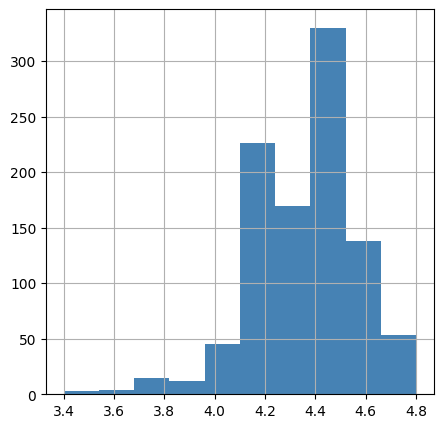

In [54]:
print(df['Rating'].describe())
df['Rating'].hist(bins=10, color = "steelblue", figsize=(5,5))

In [55]:
products = df["INDEX"].unique().tolist()
len(products)

995

In [56]:
# shuffle customer ID's
random.shuffle(products)

# extract 90% of customer ID's
customers_train = [products[i] for i in range(round(0.9*len(products)))]

# split data into train and validation set
train_df = df[df['INDEX'].isin(customers_train)]
validation_df = df[~df['INDEX'].isin(customers_train)]

In [57]:
"""# list to capture purchase history of the customers
products_train = [sentence.split() for sentence in train_df["Overview"]]

# populate the list with the product codes
for i in tqdm(products_train):
    temp = train_df[train_df["INDEX"] == i]["Overview"].tolist()
    products_train.append(temp)"""

# create a set of unique indices from the train_df dataframe
unique_indices = set(train_df["INDEX"])

# list to capture purchase history of the customers
products_train = []

# populate the list with the product codes
for i in tqdm(unique_indices):
    temp = train_df[train_df["INDEX"] == i]["Overview"].tolist()
    temp = [sentence.split() for sentence in temp]
    products_train.extend(temp)

100%|██████████| 896/896 [00:00<00:00, 8762.15it/s]


In [58]:
print(len(products_train))

896


**Build word2vec Embeddings for Products**

In [59]:
# train word2vec model
model = Word2Vec(window=10, sg=1, hs=0, negative=10,
                 alpha=0.03, min_alpha=0.0007, seed=14)

model.build_vocab(products_train, progress_per=50)

model.train(products_train, total_examples=model.corpus_count, 
            epochs=10, report_delay=1)

(134351, 285360)

In [60]:
# save word2vec model
model.save("word2vec_1.model")

In [61]:
model.init_sims(replace=True)

In [62]:
print(model)

Word2Vec<vocab=707, vector_size=100, alpha=0.03>


In [63]:
# get all word vectors from the trained model
word_vectors = model.wv

# extract all vectors
X = []
for word in word_vectors.index_to_key:
    X.append(word_vectors.get_vector(word))

X = np.array(X)
print(X.shape)

(707, 100)


In [69]:
! pip install umap-learn

In [65]:
! pip install --upgrade umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 21.5 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=dd8a8d7ecfa991bcf145c859fd1405c09c3159d358d65b88aa14e6a47378251a
  Stored in directory: /Users/V/Library/Caches/pip/wheels/02/15/cd/b456fcce97d704f38b583aecf7fa174860b6ff0b499f51f95a
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=55946749f30cc22bb12370e9f87b361893d2c78f0441031815136294329ae60d
  Stored in directory: /Users/V/Library/Caches/pip/wheels/a9/a3/51/2411ea852380d31c4cbfee910744f4effe1fef7438b199d496
Successful

In [76]:
import umap
print(umap.__file__)

/opt/homebrew/lib/python3.11/site-packages/umap/__init__.py


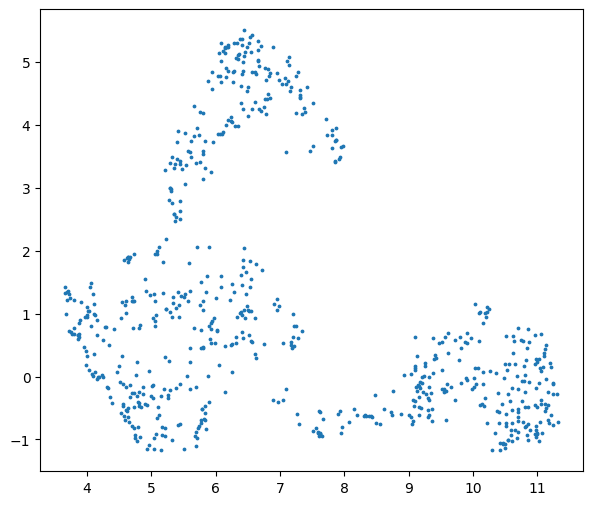

In [80]:
#Visualize the embeddings
import umap.umap_ as umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(7,6))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [82]:
perfumes = train_df[["Overview", "Fragrance"]]

# remove duplicates
perfumes.drop_duplicates(inplace=True, subset='Overview', keep="last")

# create product-ID and product-description dictionary
perfumes_dict = perfumes.groupby('Overview')['Fragrance'].apply(list).to_dict()

In [83]:
def similar_products(v, n = 3):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (perfumes_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms 






**GPT CODE** 

DIDN'T WORK!!

In [86]:
if 'Bombshell' in model.wv.index_to_key:
    print("The word 'Bombshell' is present in the vocabulary")
else:
    print("The word 'Bombshell' is not present in the vocabulary")

The word 'Bombshell' is not present in the vocabulary


In [102]:
input_fragrance = 'Unisex,Sean John,0.125,Mandarin, Bergamot, Cardamom,Tangerine, Orange Blossom, Geranium,Fig Leaves, Smoky Suede, Leather,A spicy and aromatic fragrance that captures the feeling of being up all night and the energy of the city.,Moderate,Fall & Winter,Casual (Daytime),Moderate,Expensive,4.5'

# Get the corresponding overview and infer its vector
overview = perfumes.loc[perfumes['Fragrance'] == input_fragrance, 'Overview'].iloc[0]
fragrance_vector = model.wv[overview.split()]

# Compute the cosine similarity between the input fragrance and all other fragrances
similarities = model.wv.cosine_similarities(fragrance_vector, model.wv.vectors)

# Get the indices of the 3 fragrances with the highest cosine similarity
top_indices = similarities.argsort()[:-4:-1]

# Get the names of the 3 recommended fragrances
recommended_fragrances = perfumes.iloc[top_indices]['Fragrance'].tolist()

print('Input fragrance:', input_fragrance)
print('Recommended fragrances:', recommended_fragrances)

IndexError: single positional indexer is out-of-bounds

In [91]:
overview = perfumes.loc[perfumes['Fragrance'] == input_fragrance, 'Overview'].iloc[0]

Input fragrance: Bombshell
Recommended fragrances: ['1 Million', 'Alien', '1740']

Input fragrance overview:
 Purple passionfruit, Shangri-la peony, Vanilla orchid 
 Sun-drenched citrus, Starfruit, Jasmine petals 
 Vanilla, Driftwood, Sensual musk

Recommended fragrances overview:
1 Million :
 Blood Mandarin, Peppermint 
 Rose, Cinnamon 
 Leather, Amber
Alien :
 Sambac Jasmine, Cashmeran Wood, Ambergris 
 Solar Notes 
 White Amber
1740 :
 Bergamot, davana, birch tar 
 Patchouli, cedar, lavender, vanilla 
 Leather, amber, vanilla, immortelle
